In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table

import nbodykit
from nbodykit.lab import *
#from nbodykit import style, setup_logging

from matplotlib import pyplot as plt

import sys
sys.path.append('../code')
import plotter

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set parameters

In [2]:
redshift = 0.7
cosmo = nbodykit.cosmology.Planck15
Plin = nbodykit.cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')
b1_gal = 1.5
b1_agn = 2.5

Nmesh = 512
seed = 42

# ndens_gal = 1e-3
# ndens_agn = 1e-5
ndens_gal = 1e-4
ndens_agn = 1e-5

In [3]:
# how big a box do we need to go up to our desired zmax?
z_max = 1.4
dist_max = cosmo.comoving_distance(z_max)
print(dist_max)
boxsize = np.ceil(dist_max*2/500)*500 # times two because need on all sides; round to nearest 500
print(boxsize)

2903.092217020708
6000.0


In [4]:
# Number density consideration: For optimal results, you generally want the mesh resolution to be fine enough to resolve the mean inter-particle separation. If your galaxy number density is n, then the mean separation is approximately n^(-1/3). A good rule of thumb is to have your cell size (boxsize/nmesh) be smaller than this mean separation.
# Nyquist frequency: The nmesh parameter determines the maximum wavenumber (kmax) that can be resolved, which is π × nmesh/boxsize. This is important when considering the power spectrum analysis.

In [5]:
print(f'Mean interparticle separation galaxies: {1/np.cbrt(ndens_gal):.2f}')
print(f'Mean interparticle separation AGN: {1/np.cbrt(ndens_agn):.2f}')
print(f'Physical resolution: {boxsize/Nmesh:.2f} Mpc/h')
freq_nyquest = np.pi*Nmesh/boxsize
print(f'Nyquist frequency: {freq_nyquest:.2f} h/Mpc')

Mean interparticle separation galaxies: 21.54
Mean interparticle separation AGN: 46.42
Physical resolution: 11.72 Mpc/h
Nyquist frequency: 0.27 h/Mpc


### Generate tracer catalogs

In [6]:
# two catalogs with same seed should trace same underlying distribution
cat_gal = nbodykit.lab.LogNormalCatalog(Plin=Plin, nbar=ndens_gal, BoxSize=boxsize, Nmesh=Nmesh, bias=b1_gal, seed=seed)
cat_agn = nbodykit.lab.LogNormalCatalog(Plin=Plin, nbar=ndens_agn, BoxSize=boxsize, Nmesh=Nmesh, bias=b1_agn, seed=seed)

In [7]:
print(len(cat_gal['Position']))
print(len(cat_agn['Position']))

21602022
2160818


Text(0, 0.5, 'y [Mpc/h]')

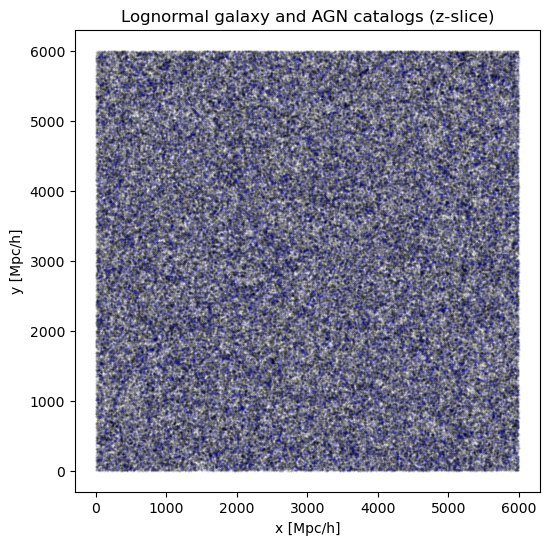

In [29]:
plt.figure(figsize=(6,6))
i_zslice_gal = cat_gal['Position'][:,2] < boxsize/50
plt.scatter(cat_gal['Position'][:,0][i_zslice_gal], cat_gal['Position'][:,1][i_zslice_gal], c='k', alpha=0.1, s=0.2)
i_zslice_agn = cat_agn['Position'][:,2] < boxsize/50
plt.scatter(cat_agn['Position'][:,0][i_zslice_agn], cat_agn['Position'][:,1][i_zslice_agn], c='b', alpha=0.1, s=0.4)
plt.title("Lognormal galaxy and AGN catalogs (z-slice)")
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')

In [9]:
ra_gal, dec_gal, z_gal = nbodykit.transform.CartesianToSky(cat_gal['Position'], cosmo, velocity=cat_gal['Velocity'], 
                                               zmax=100, observer=[boxsize/2, boxsize/2, boxsize/2])
ra_agn, dec_agn, z_agn = nbodykit.transform.CartesianToSky(cat_agn['Position'], cosmo, velocity=cat_agn['Velocity'], 
                                               zmax=100, observer=[boxsize/2, boxsize/2, boxsize/2])

In [10]:
# cut at redshift smaller than boxsize/2 so we have a sphere
i_zmax_gal = z_gal < z_max
ra_gal, dec_gal, z_gal = ra_gal[i_zmax_gal], dec_gal[i_zmax_gal], z_gal[i_zmax_gal]
i_zmax_agn = z_agn < z_max
ra_agn, dec_agn, z_agn = ra_agn[i_zmax_agn], dec_agn[i_zmax_agn], z_agn[i_zmax_agn]


(<Figure size 1000x600 with 1 Axes>, <MollweideAxes: >)

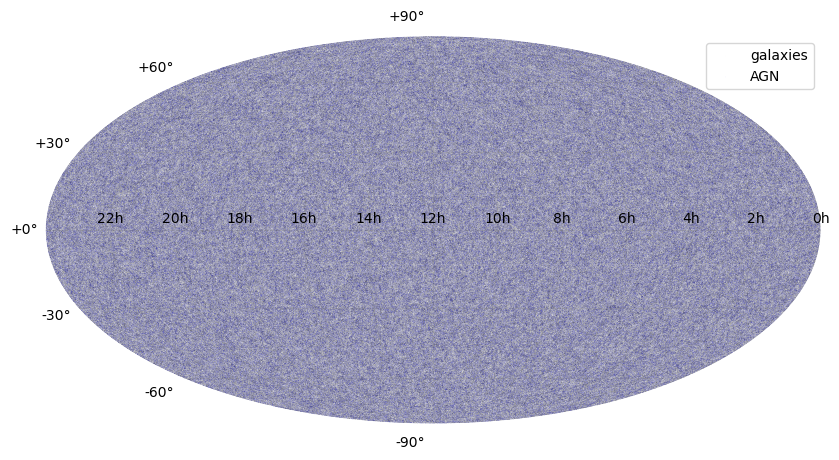

In [31]:
ra_arr = [ra_gal.compute(), ra_agn.compute()]
dec_arr = [dec_gal.compute(), dec_agn.compute()]
c_arr = ['k', 'b']
alpha_arr = [0.05, 0.1]
s_arr = [0.1, 0.2]
label_arr = ['galaxies', 'AGN']

plotter.create_skyplot(ra_arr, dec_arr, alpha_arr=alpha_arr, s_arr=s_arr, c_arr=c_arr, label_arr=label_arr)

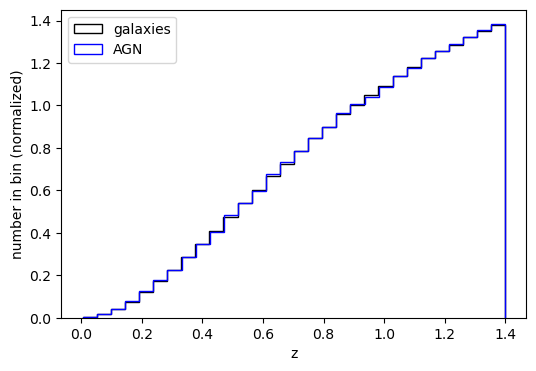

In [12]:
plt.figure(figsize=(6,4))
plt.hist(z_gal.compute(), bins=30, histtype='step', color='k', label='galaxies', density=True)
plt.hist(z_agn.compute(), bins=30, histtype='step', color='b', label='AGN', density=True)
plt.xlabel('z')
plt.ylabel('number in bin (normalized)')
plt.legend()

In [13]:
# Convert catalogs to mesh objects
mesh_gal = cat_gal.to_mesh(resampler='tsc', Nmesh=Nmesh, compensated=True, position='Position')
mesh_agn = cat_agn.to_mesh(resampler='tsc', Nmesh=Nmesh, compensated=True, position='Position')

In [14]:
r_cross = nbodykit.lab.FFTPower(first=mesh_gal, second=mesh_agn, mode='1d', dk=0.005)
r_gal = nbodykit.lab.FFTPower(first=mesh_gal, second=mesh_gal, mode='1d', dk=0.005)
r_agn = nbodykit.lab.FFTPower(first=mesh_agn, second=mesh_agn, mode='1d', dk=0.005)


In [15]:
# Get the power spectrum results
k = r_cross.power['k']
Pk_cross = r_cross.power['power'].real  # cross-spectrum is complex, take real part
Pk_gal = r_gal.power['power'].real  # auto-spectrum of galaxies
Pk_agn = r_agn.power['power'].real  # auto-spectrum of AGN

### Null check using diff random seed:

In [16]:
cat_agn_2 = nbodykit.lab.LogNormalCatalog(Plin=Plin, nbar=1e-7, BoxSize=boxsize, Nmesh=Nmesh, bias=b1_agn, seed=24)

In [17]:
mesh_agn2 = cat_agn_2.to_mesh(resampler='tsc', Nmesh=512, compensated=True, position='Position')
r_cross2 = nbodykit.lab.FFTPower(first=mesh_gal, second=mesh_agn2, mode='1d', dk=0.005)
r_agn2 = nbodykit.lab.FFTPower(first=mesh_agn2, second=mesh_agn2, mode='1d', dk=0.005)

In [18]:
Pk_cross2 = r_cross2.power['power'].real  # cross-spectrum is complex, take real part
Pk_agn2 = r_agn2.power['power'].real  # auto-spectrum of AGN

### Plot results

In [19]:
print(2*np.pi/boxsize)
print(freq_nyquest)

0.0010471975511965976
0.268082573106329


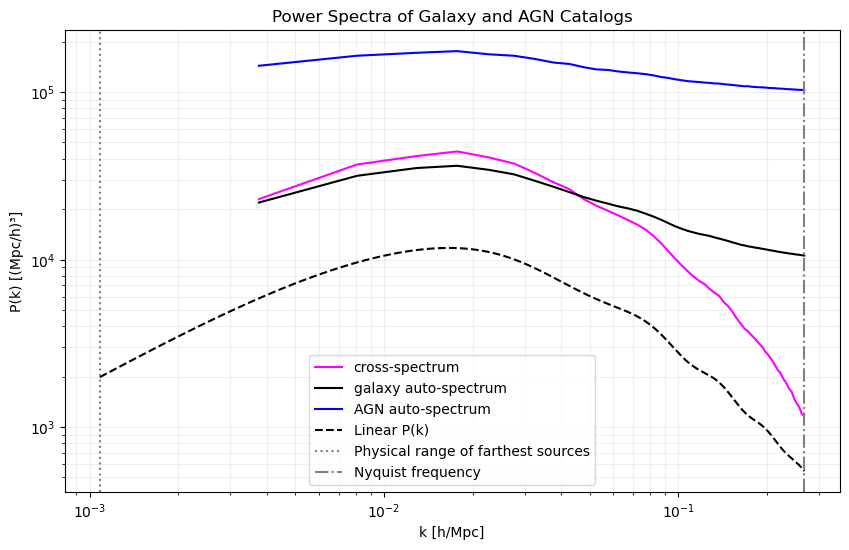

In [24]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot the power spectra
plt.loglog(k, Pk_cross, color='magenta', ls='-', label='cross-spectrum')
#plt.loglog(k, Pk_cross2, color='gray', ls=':', label='null cross-spectrum')
plt.loglog(k, Pk_gal, color='k', label='galaxy auto-spectrum')
plt.loglog(k, Pk_agn, color='b', label='AGN auto-spectrum')
#plt.loglog(k, Pk_agn2, color='o', label='AGN auto-spectrum (2)')

k_min, k_max = 2*np.pi/(2*dist_max), freq_nyquest
k_lin = np.logspace(np.log10(k_min), np.log10(k_max), 1000)  # k range from 0.001 to 10 h/Mpc
plt.loglog(k_lin, Plin(k_lin), 'k--', label='Linear P(k)')
plt.axvline(k_min, color='grey', ls=':', label='Physical range of farthest sources')
plt.axvline(k_max, color='grey', ls='-.', label='Nyquist frequency')

# Enhance the main plot
plt.xlabel('k [h/Mpc]')
plt.ylabel('P(k) [(Mpc/h)³]')
plt.title('Power Spectra of Galaxy and AGN Catalogs')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

In [21]:
## Choose sources to host GWs
## TODO deal with completeness!
f_agn_phys = 0.2
f_agn_comp = 1
f_gal_phys = 1 - f_agn_phys
f_gal_comp = 1

In [22]:
n_gw = 100
i_gw_agn = np.random.randint(0, len(ra_agn.compute()), int(f_agn_phys*n_gw))
i_gw_gal = np.random.randint(0, len(ra_gal.compute()), int(f_gal_phys*n_gw))

(<Figure size 1000x600 with 1 Axes>, <MollweideAxes: >)

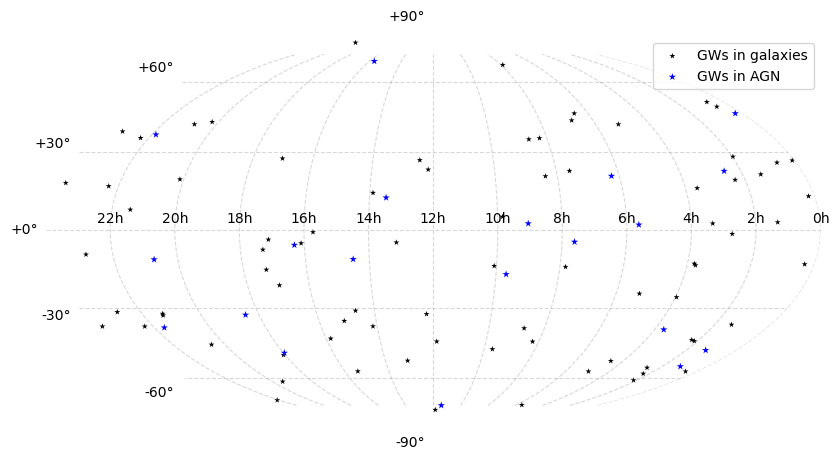

In [23]:
ra_gal_gw = ra_gal

ra_arr = [ra_gal.compute()[i_gw_gal], ra_agn.compute()[i_gw_agn]]
dec_arr = [dec_gal.compute()[i_gw_gal], dec_agn.compute()[i_gw_agn]]
c_arr = ['k', 'b']
alpha_arr = [1, 1]
s_arr = [20, 30]
label_arr = ['GWs in galaxies', 'GWs in AGN']
marker_arr = ['*', '*']

plotter.create_skyplot(ra_arr, dec_arr, alpha_arr=alpha_arr, s_arr=s_arr, 
                       c_arr=c_arr, label_arr=label_arr, marker_arr=marker_arr)